In [21]:
import torch
import torch.utils.data
import time
import os
import numpy as np
import csv
import dgl
from dgl.data.utils import load_graphs
import networkx as nx
from tqdm import tqdm
import random
random.seed(42)
from sklearn.model_selection import StratifiedKFold, train_test_split

class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, name, threshold=0.3, edge_ratio=0.2, node_feat_transform='pearson'):
        t0 = time.time()
        self.name = name

        G_dataset, Labels = load_graphs(name2path[self.name])

        self.node_num = G_dataset[0].ndata['N_features'].size(0)

        print("[!] Dataset: ", self.name)

        # transfer DGLHeteroGraph to DGLFormDataset
        data = []
        error_case = []
        for i in range(len(G_dataset)):
            if len(((G_dataset[i].ndata['N_features'] != 0).sum(dim=-1) == 0).nonzero()) > 0:
                error_case.append(i)
        print(error_case)
        G_dataset = [n for i, n in enumerate(G_dataset) if i not in error_case]

        for i in tqdm(range(len(G_dataset))):
            if edge_ratio:
                threshold_idx = int(len(G_dataset[i].edata['E_features']) * (1 - edge_ratio))
                threshold = sorted(G_dataset[i].edata['E_features'].tolist())[threshold_idx]

            G_dataset[i].remove_edges(torch.squeeze((torch.abs(G_dataset[i].edata['E_features']) < float(threshold)).nonzero()))
            # G_dataset[i].edata['E_features'][G_dataset[i].edata['E_features'] < 0] = 0
            G_dataset[i].edata['feat'] = G_dataset[i].edata['E_features'].unsqueeze(-1).clone()

            if name[:-7] == 'pearson' or node_feat_transform == 'original':
                G_dataset[i].ndata['feat'] = G_dataset[i].ndata['N_features'].clone()
            elif node_feat_transform == 'one_hot':
                G_dataset[i].ndata['feat'] = torch.eye(self.node_num).clone()
            elif node_feat_transform == 'pearson':
                G_dataset[i].ndata['feat'] = torch.from_numpy(np.corrcoef(G_dataset[i].ndata['N_features'].numpy())).clone()
            elif node_feat_transform == '3d_coor':
                G_dataset[i].ndata['feat'] = torch.from_numpy(self.get_3d_corr()).clone()
            elif node_feat_transform == 'degree':
                G_dataset[i].ndata['feat'] = G_dataset[i].in_degrees().unsqueeze(dim=1).clone()
                # G_dataset[i].ndata['feat'] = G_dataset[i].adj().to_dense().sum(dim=0).unsqueeze(dim=1).clone()
            elif node_feat_transform == 'adj_matrix':
                G_dataset[i].ndata['feat'] = G_dataset[i].adj().to_dense().clone()
            elif node_feat_transform == 'mean_std':
                G_dataset[i].ndata['feat'] = torch.stack(torch.std_mean(G_dataset[i].ndata['N_features'], dim=-1)).T.flip(dims=[1]).clone()
            elif node_feat_transform == 'concat':
                # [degree | pearson | mean | std | coor]
                degree = G_dataset[i].in_degrees().unsqueeze(dim=1).clone()
                pearson = torch.from_numpy(np.corrcoef(G_dataset[i].ndata['N_features'].numpy()))
                mean_std = torch.stack(torch.std_mean(G_dataset[i].ndata['N_features'], dim=-1)).T.flip(dims=[1])
                coor = torch.from_numpy(self.get_3d_corr())
                G_dataset[i].ndata['feat'] = torch.cat([degree, pearson, mean_std, coor], dim=-1).clone()
            else:
                raise NotImplementedError

            G_dataset[i].ndata.pop('N_features')
            G_dataset[i].edata.pop('E_features')
            data.append([G_dataset[i], Labels['glabel'].tolist()[i]])
        
        self.dataset = self.format_dataset(data)
        dataset = self.format_dataset(data)
        # this function splits data into train/val/test and returns the indices
        self.all_idx = self.get_all_split_idx(dataset)

        self.all = dataset
        self.train = [self.format_dataset([dataset[idx] for idx in self.all_idx['train'][split_num]]) for split_num in range(10)]
        self.val = [self.format_dataset([dataset[idx] for idx in self.all_idx['val'][split_num]]) for split_num in range(10)]
        self.test = [self.format_dataset([dataset[idx] for idx in self.all_idx['test'][split_num]]) for split_num in range(10)]
        
        # After processing all graphs, use the first graph to determine feature dimension
        self.node_feat_dim = G_dataset[0].ndata['feat'].shape[1]
        
        print("Time taken: {:.4f}s".format(time.time()-t0))

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)
    
    def get_all_split_idx(self, dataset):
        """
            - Split total number of graphs into 3 (train, val and test) in 80:10:10
            - Stratified split proportionate to original distribution of data with respect to classes
            - Using sklearn to perform the split and then save the indexes
            - Preparing 10 such combinations of indexes split to be used in Graph NNs
            - As with KFold, each of the 10 fold have unique test set.
        """
        root_idx_dir = './data/{}/'.format(self.name)
        if not os.path.exists(root_idx_dir):
            os.makedirs(root_idx_dir)
        all_idx = {}

        # If there are no idx files, do the split and store the files
        if not (os.path.exists(root_idx_dir + 'train.index')):
            print("[!] Splitting the data into train/val/test ...")

            # Using 10-fold cross val to compare with benchmark papers
            k_splits = 10

            cross_val_fold = StratifiedKFold(n_splits=k_splits, shuffle=True)
            k_data_splits = []

            # this is a temporary index assignment, to be used below for val splitting
            for i in range(len(dataset.graph_lists)):
                dataset[i][0].a = lambda: None
                setattr(dataset[i][0].a, 'index', i)

            for indexes in cross_val_fold.split(dataset.graph_lists, dataset.graph_labels):
                remain_index, test_index = indexes[0], indexes[1]

                remain_set = self.format_dataset([dataset[index] for index in remain_index])

                # Gets final 'train' and 'val'
                train, val, _, __ = train_test_split(remain_set,
                                                     range(len(remain_set.graph_lists)),
                                                     test_size=0.111,
                                                     stratify=remain_set.graph_labels)

                train, val = self.format_dataset(train), self.format_dataset(val)
                test = self.format_dataset([dataset[index] for index in test_index])

                # Extracting only idx
                idx_train = [item[0].a.index for item in train]
                idx_val = [item[0].a.index for item in val]
                idx_test = [item[0].a.index for item in test]

                f_train_w = csv.writer(open(root_idx_dir + 'train.index', 'a+'))
                f_val_w = csv.writer(open(root_idx_dir + 'val.index', 'a+'))
                f_test_w = csv.writer(open(root_idx_dir + 'test.index', 'a+'))

                f_train_w.writerow(idx_train)
                f_val_w.writerow(idx_val)
                f_test_w.writerow(idx_test)

            print("[!] Splitting done!")

        # reading idx from the files
        for section in ['train', 'val', 'test']:
            with open(root_idx_dir + section + '.index', 'r') as f:
                reader = csv.reader(f)
                all_idx[section] = [list(map(int, idx)) for idx in reader]
        return all_idx

    def format_dataset(self, dataset):  
        """
            Utility function to recover data,
            INTO-> dgl/pytorch compatible format 
        """
        graphs = [data[0] for data in dataset]
        labels = [data[1] for data in dataset]

        for graph in graphs:
            #graph.ndata['feat'] = torch.FloatTensor(graph.ndata['feat'])
            graph.ndata['feat'] = graph.ndata['feat'].float() # dgl 4.0
            # adding edge features for Residual Gated ConvNet, if not there
            if 'feat' not in graph.edata.keys():
                edge_feat_dim = graph.ndata['feat'].shape[1] # dim same as node feature dim
                graph.edata['feat'] = torch.ones(graph.number_of_edges(), edge_feat_dim)

        return DGLFormDataset(graphs, labels)
    
    
    # form a mini batch from a given list of samples = [(graph, label) pairs]
    def collate(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels = map(list, zip(*samples))
        labels = torch.tensor(np.array(labels))
        #tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
        #tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
        #snorm_n = torch.cat(tab_snorm_n).sqrt()  
        #tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
        #tab_snorm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
        #snorm_e = torch.cat(tab_snorm_e).sqrt()
        batched_graph = dgl.batch(graphs)
        
        return batched_graph, labels
    
    
    # prepare dense tensors for GNNs using them; such as RingGNN, 3WLGNN
    def collate_dense_gnn(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels = map(list, zip(*samples))
        labels = torch.tensor(np.array(labels))
        #tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
        #tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
        #snorm_n = tab_snorm_n[0][0].sqrt()  
        
        #batched_graph = dgl.batch(graphs)
    
        g = graphs[0]
        adj = self._sym_normalize_adj(g.adjacency_matrix().to_dense())        
        """
            Adapted from https://github.com/leichen2018/Ring-GNN/
            Assigning node and edge feats::
            we have the adjacency matrix in R^{n x n}, the node features in R^{d_n} and edge features R^{d_e}.
            Then we build a zero-initialized tensor, say T, in R^{(1 + d_n + d_e) x n x n}. T[0, :, :] is the adjacency matrix.
            The diagonal T[1:1+d_n, i, i], i = 0 to n-1, store the node feature of node i. 
            The off diagonal T[1+d_n:, i, j] store edge features of edge(i, j).
        """

        zero_adj = torch.zeros_like(adj)
        
        in_dim = g.ndata['feat'].shape[1]
        
        # use node feats to prepare adj
        adj_node_feat = torch.stack([zero_adj for j in range(in_dim)])
        adj_node_feat = torch.cat([adj.unsqueeze(0), adj_node_feat], dim=0)
        
        for node, node_feat in enumerate(g.ndata['feat']):
            adj_node_feat[1:, node, node] = node_feat

        x_node_feat = adj_node_feat.unsqueeze(0)
        
        return x_node_feat, labels
    
    def _sym_normalize_adj(self, adj):
        deg = torch.sum(adj, dim = 0)#.squeeze()
        deg_inv = torch.where(deg>0, 1./torch.sqrt(deg), torch.zeros(deg.size()))
        deg_inv = torch.diag(deg_inv)
        return torch.mm(deg_inv, torch.mm(adj, deg_inv))

    def _add_self_loops(self):

        # function for adding self loops
        # this function will be called only if self_loop flag is Trueq
        for split_num in range(10):
            self.train[split_num].graph_lists = [self_loop(g) for g in self.train[split_num].graph_lists]
            self.val[split_num].graph_lists = [self_loop(g) for g in self.val[split_num].graph_lists]
            self.test[split_num].graph_lists = [self_loop(g) for g in self.test[split_num].graph_lists]
            
        for split_num in range(10):
            self.train[split_num] = DGLFormDataset(self.train[split_num].graph_lists, self.train[split_num].graph_labels)
            self.val[split_num] = DGLFormDataset(self.val[split_num].graph_lists, self.val[split_num].graph_labels)
            self.test[split_num] = DGLFormDataset(self.test[split_num].graph_lists, self.test[split_num].graph_labels)

    def get_3d_corr(self):
        path = name2path[self.name]
        with open(path, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='\n')
            if self.name not in ['abide_schaefer100', 'abide_AAL116']:
                coor = [row[1:] for row in spamreader][1:]
            else:
                coor = [row[1:] for row in spamreader]
        return np.array(coor, dtype='float')
    
class DGLFormDataset(torch.utils.data.Dataset):
    """
        DGLFormDataset wrapping graph list and label list as per pytorch Dataset.
        *lists (list): lists of 'graphs' and 'labels' with same len().
    """
    def __init__(self, *lists):
        assert all(len(lists[0]) == len(li) for li in lists)
        self.lists = lists
        self.graph_lists = lists[0]
        self.graph_labels = lists[1]

    def __getitem__(self, index):
        return tuple(li[index] for li in self.lists)

    def __len__(self):
        return len(self.lists[0])    
    
def self_loop(g):
    """
        Utility function only, to be used only when necessary as per user self_loop flag
        : Overwriting the function dgl.transform.add_self_loop() to not miss ndata['feat'] and edata['feat']
        
        
        This function is called inside a function in TUsDataset class.
    """
    new_g = dgl.DGLGraph()
    new_g.add_nodes(g.number_of_nodes())
    new_g.ndata['feat'] = g.ndata['feat']
    
    src, dst = g.all_edges(order="eid")
    src = dgl.backend.zerocopy_to_numpy(src)
    dst = dgl.backend.zerocopy_to_numpy(dst)
    non_self_edges_idx = src != dst
    # print(non_self_edges_idx)
    nodes = np.arange(g.number_of_nodes())
    new_g.add_edges(src[non_self_edges_idx], dst[non_self_edges_idx])
    new_g.add_edges(nodes, nodes)
    
    # This new edata is not used since this function gets called only for GCN, GAT
    # However, we need this for the generic requirement of ndata and edata
    new_g.edata['feat'] = torch.zeros(new_g.number_of_edges())
    return new_g

In [29]:
name2path = {
    # Put bin files here
    'Abide100Dataset': '/home/marcus/Brain-Network-Benchmark/data/Jupyter/abide_schaefer100.bin',
}

Abide100 = BrainDataset('Abide100Dataset')

[!] Dataset:  Abide100Dataset
[]


  0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 2.9031s


#### Girvan-Newman

In [23]:
import torch
import dgl
import networkx as nx
import numpy as np
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

# Assuming your BrainDataset class is defined and loaded as previously shared

# Function to convert DGL graph to simplified NetworkX graph
def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Use a default weight if not specified
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

def apply_girvan_newman(graph):
    communities_generator = nx.algorithms.community.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    return sorted(map(sorted, top_level_communities))

def extract_community_features(graph):
    communities = apply_girvan_newman(graph)
    num_communities = len(communities)
    avg_community_size = np.mean([len(c) for c in communities])
    community_size_variance = np.var([len(c) for c in communities])

    # Additional advanced feature calculations
    edge_density_within = [nx.density(graph.subgraph(community)) for community in communities]
    avg_edge_density_within = np.mean(edge_density_within) if edge_density_within else 0

    # Cohesion and separation could be calculated based on your specific definition
    # Here's a simple example for cohesion as average internal edge density
    cohesion = avg_edge_density_within
    # Separation could be defined as the difference between maximum and minimum community sizes
    separation = max([len(c) for c in communities]) - min([len(c) for c in communities])

    return (num_communities, avg_community_size, community_size_variance, avg_edge_density_within, cohesion, separation)

# Extracting features with progress tracking
features = np.array([extract_community_features(to_simple_graph(graph)) for graph in tqdm(graphs, desc="Processing Graphs")])

# Example of statistical analysis
# Here, you compare the number of communities between two groups using a T-test
labels_array = np.array(labels)
features_0 = features[labels_array == 0]
features_1 = features[labels_array == 1]

t_stat, p_value = ttest_ind(features_0[:, 0], features_1[:, 0])  # Comparing the number of communities
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# The code above outlines the full process including converting graphs, extracting community-related features,
# and performing a basic statistical analysis. Adjust the definitions of cohesion and separation as necessary
# to fit your specific dataset and research questions.

[!] Dataset:  Abide100Dataset
[]


  0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 2.8433s


Processing Graphs:   0%|          | 0/1025 [00:00<?, ?it/s]

KeyboardInterrupt: 

Number of Communities:
  Label 0 - Mean: 2.02, Median: 2.00, Std: 0.16
  Label 1 - Mean: 2.04, Median: 2.00, Std: 0.27

Average Community Size:
  Label 0 - Mean: 49.72, Median: 50.00, Std: 2.31
  Label 1 - Mean: 49.49, Median: 50.00, Std: 3.18

Community Size Variance:
  Label 0 - Mean: 2377.52, Median: 2401.00, Std: 153.08
  Label 1 - Mean: 2366.63, Median: 2401.00, Std: 142.58

Average Edge Density Within:
  Label 0 - Mean: 0.20, Median: 0.17, Std: 0.19
  Label 1 - Mean: 0.24, Median: 0.17, Std: 0.28

Cohesion:
  Label 0 - Mean: 0.20, Median: 0.17, Std: 0.19
  Label 1 - Mean: 0.24, Median: 0.17, Std: 0.28

Separation:
  Label 0 - Mean: 97.55, Median: 98.00, Std: 3.73
  Label 1 - Mean: 97.46, Median: 98.00, Std: 2.66



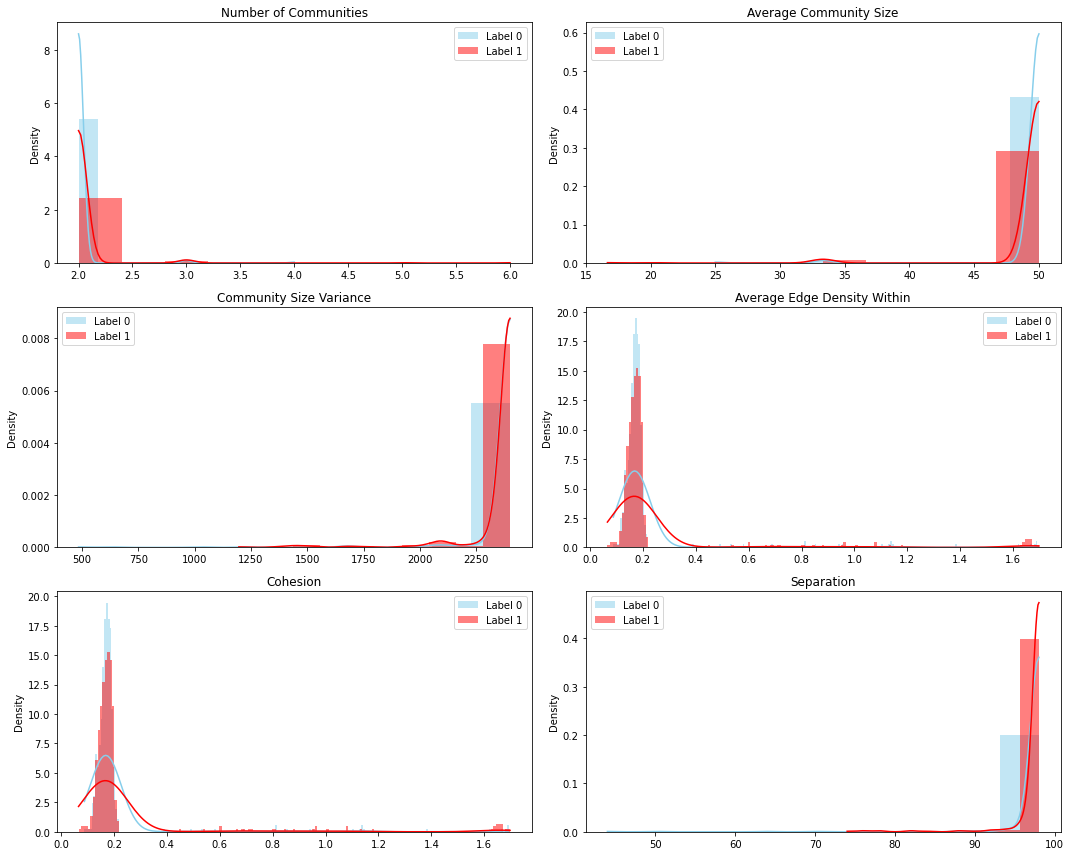

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've extracted the features as per the previous example

# Print basic statistics for each feature
feature_names = ['Number of Communities', 'Average Community Size', 'Community Size Variance', 
                 'Average Edge Density Within', 'Cohesion', 'Separation']

for i, name in enumerate(feature_names):
    feature_0 = features_0[:, i]
    feature_1 = features_1[:, i]
    
    print(f"{name}:")
    print(f"  Label 0 - Mean: {np.mean(feature_0):.2f}, Median: {np.median(feature_0):.2f}, Std: {np.std(feature_0):.2f}")
    print(f"  Label 1 - Mean: {np.mean(feature_1):.2f}, Median: {np.median(feature_1):.2f}, Std: {np.std(feature_1):.2f}")
    print("")

# Visualization
def plot_feature_distributions(features_0, features_1, feature_names):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, name in enumerate(feature_names):
        sns.histplot(features_0[:, i], ax=axes[i], color="skyblue", label='Label 0', kde=True, stat="density", linewidth=0)
        sns.histplot(features_1[:, i], ax=axes[i], color="red", label='Label 1', kde=True, stat="density", linewidth=0)
        axes[i].set_title(name)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_feature_distributions(features_0, features_1, feature_names)

##### Kolmogorov-Smirnov (KS) Test to compare the distribution of the clustering coefficient, degree distribution, and edge weights between the two labels.

##### Visualization of these distributions to provide visual insight into the differences.

##### Analysis of Clustering Coefficient, Degree Distribution, and Edge Weights to explore specific network characteristics that may differ between labels.

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert DGLGraphs to NetworkX graphs
nx_graphs = [to_simple_graph(graph) for graph in tqdm(graphs, desc="Converting graphs")]

# Calculate clustering coefficients
clustering_coeffs = [nx.clustering(g) for g in nx_graphs]

# Get clustering coefficients for each label
clustering_label_0 = [coeff for graph, coeffs in zip(nx_graphs, clustering_coeffs) 
                      for node, coeff in coeffs.items() if labels[graphs.index(graph)] == 0]
clustering_label_1 = [coeff for graph, coeffs in zip(nx_graphs, clustering_coeffs) 
                      for node, coeff in coeffs.items() if labels[graphs.index(graph)] == 1]

# Perform the Kolmogorov-Smirnov test for clustering coefficients
ks_stats_clustering, ks_p_values_clustering = ks_2samp(clustering_label_0, clustering_label_1)
print("KS test for clustering coefficients:", ks_stats_clustering, ks_p_values_clustering)

# Calculate degree distributions
degree_distributions = [dict(g.degree()) for g in nx_graphs]

# Get degree distributions for each label
degree_label_0 = [degree for graph, degrees in zip(nx_graphs, degree_distributions) 
                  for node, degree in degrees.items() if labels[graphs.index(graph)] == 0]
degree_label_1 = [degree for graph, degrees in zip(nx_graphs, degree_distributions) 
                  for node, degree in degrees.items() if labels[graphs.index(graph)] == 1]

# Perform the Kolmogorov-Smirnov test for degree distributions
ks_stats_degree, ks_p_values_degree = ks_2samp(degree_label_0, degree_label_1)
print("KS test for degree distributions:", ks_stats_degree, ks_p_values_degree)

# Visualization of degree distributions
degree_df = pd.DataFrame({
    "Degree": [degree for degree_dict in degree_distributions for degree in degree_dict.values()],
    "Label": [label for graph in nx_graphs for label in [labels[graph.graph['id']]]*nx.number_of_nodes(graph)]
})

plt.figure(figsize=(12, 6))
sns.histplot(data=degree_df, x="Degree", hue="Label", element="step", stat="density", common_norm=False)
plt.title("Degree Distributions by Label")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.legend(title="Label")
plt.show()

# Assuming graphs have weighted edges, analyze edge weight distributions
# You'll need to adjust 'weight' to the actual attribute name used in your dataset
if nx.get_edge_attributes(nx_graphs[0], 'weight'):
    edge_weights = [data['weight'] for g in nx_graphs for u, v, data in g.edges(data=True)]
    
    # Perform the Kolmogorov-Smirnov test for edge weight distributions
    ks_stats_edge_weight, ks_p_values_edge_weight = ks_2samp(
        [data['weight'] for graph in nx_graphs for u, v, data in graph.edges(data=True) if labels[graph.graph['id']] == 0],
        [data['weight'] for graph in nx_graphs for u, v, data in graph.edges(data=True) if labels[graph.graph['id']] == 1]
    )
    
    print("KS test for edge weight distributions:", ks_stats_edge_weight, ks_p_values_edge_weight)

    # Visualization of edge weight distributions
    edge_weight_df = pd.DataFrame({
        "Edge Weight": edge_weights,
        "Label": [label for graph in nx_graphs for label in [labels[graph.graph['id']]]*nx.number_of_edges(graph)]
    })

    plt.figure(figsize=(12, 6))
    sns.histplot(data=edge_weight_df, x="Edge Weight", hue="Label", element="step", stat="density", common_norm=False)
    plt.title("Edge Weight Distributions by Label")
    plt.xlabel("Edge Weight")
    plt.ylabel("Density")
    plt.legend(title="Label")
    plt.show()

  4%|▍         | 44/1025 [00:00<00:02, 433.66it/s]

[!] Dataset:  Abide100Dataset
[]


Converting graphs:   1%|          | 9/1025 [00:00<00:12, 83.92it/s]

Time taken: 2.9866s


Converting graphs: 100%|██████████| 1025/1025 [00:21<00:00, 47.37it/s]


ValueError: tuple.index(x): x not in tuple

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import girvan_newman
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from itertools import chain

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """ Converts a DGL graph to a simplified NetworkX graph. """
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to calculate edge density within communities
def calculate_edge_density_within(graph, partition):
    intra_edges = 0
    total_possible_intra_edges = 0
    for community in set(partition.values()):
        nodes_in_community = [nodes for nodes in partition.keys() if partition[nodes] == community]
        subgraph = graph.subgraph(nodes_in_community)
        intra_edges += subgraph.number_of_edges()
        total_possible_intra_edges += len(nodes_in_community) * (len(nodes_in_community) - 1) / 2
    return intra_edges / total_possible_intra_edges if total_possible_intra_edges else 0

# Function to calculate cohesion
def calculate_cohesion(graph, partition):
    return nx.average_clustering(graph, nodes=partition.keys(), weight='weight')

# Function to apply the Girvan-Newman method and extract the top-level partition
def apply_girvan_newman(graph):
    communities_generator = girvan_newman(graph)
    top_level_communities = next(communities_generator)
    partition = {node: i for i, community in enumerate(top_level_communities) for node in community}
    return partition

# Function to extract features
def extract_features(graphs, labels):
    features = {'Average Edge Density Within': [], 'Cohesion': [], 'Label': labels}
    for graph in graphs:
        nx_graph = to_simple_graph(graph)  # Convert DGLGraph to NetworkX graph
        partition = apply_girvan_newman(nx_graph)
        features['Average Edge Density Within'].append(calculate_edge_density_within(nx_graph, partition))
        features['Cohesion'].append(calculate_cohesion(nx_graph, partition))
    return pd.DataFrame(features)

# Calculate the features
features_df = extract_features(graphs, labels)

# Perform t-tests
for feature in ['Average Edge Density Within', 'Cohesion']:
    stat, p = ttest_ind(
        features_df[features_df['Label'] == 0][feature],
        features_df[features_df['Label'] == 1][feature]
    )
    print(f"{feature} T-test: stat = {stat:.4f}, p = {p:.4f}")

# Visualization and statistics printing
def plot_and_print_features(features_df, feature_names):
    for name in feature_names:
        feature_0 = features_df[features_df['Label'] == 0][name]
        feature_1 = features_df[features_df['Label'] == 1][name]
        
        # Print statistics
        print(f"{name}:")
        print(f"  Label 0 - Mean: {np.mean(feature_0):.2f}, Median: {np.median(feature_0):.2f}, Std: {np.std(feature_0):.2f}")
        print(f"  Label 1 - Mean: {np.mean(feature_1):.2f}, Median: {np.median(feature_1):.2f}, Std: {np.std(feature_1):.2f}")
        
        # Plot distributions
        sns.histplot(feature_0, color="skyblue", label='Label 0', kde=True, stat="density", linewidth=0)
        sns.histplot(feature_1, color="red", label='Label 1', kde=True, stat="density", linewidth=0)
        plt.title(name)
        plt.legend()
        plt.show()

# Execute the visualization and statistics printing function
plot_and_print_features(features_df, ['Average Edge Density Within', 'Cohesion'])

##### Edge classification (inter vs intra community), Edge Counting, Label comparison b/w both

In [ ]:
'''

Louvain Edge Classification

'''
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from community import community_louvain
from collections import defaultdict

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """ Converts a DGL graph to a simplified NetworkX graph. """
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

def detect_communities_louvain(graph):
    partition = community_louvain.best_partition(graph)
    return partition

def classify_edges(graph, partition):
    intra_community_edges = 0
    inter_community_edges = 0
    
    for edge in graph.edges():
        if partition[edge[0]] == partition[edge[1]]:
            intra_community_edges += 1
        else:
            inter_community_edges += 1
            
    return intra_community_edges, inter_community_edges

# Detect communities and classify edges for each graph
edges_data = {'Label': [], 'IntraCommunityEdges': [], 'InterCommunityEdges': []}

for graph, label in zip(graphs, labels):
    partition = detect_communities_louvain(graph)
    intra_edges, inter_edges = classify_edges(graph, partition)
    edges_data['Label'].append(label)
    edges_data['IntraCommunityEdges'].append(intra_edges)
    edges_data['InterCommunityEdges'].append(inter_edges)

edges_df = pd.DataFrame(edges_data)

# Perform t-tests to compare edge counts between labels
intra_t_stat, intra_p_value = ttest_ind(
    edges_df[edges_df['Label'] == 0]['IntraCommunityEdges'],
    edges_df[edges_df['Label'] == 1]['IntraCommunityEdges']
)

inter_t_stat, inter_p_value = ttest_ind(
    edges_df[edges_df['Label'] == 0]['InterCommunityEdges'],
    edges_df[edges_df['Label'] == 1]['InterCommunityEdges']
)

print(f"Intra-Community Edges - T-statistic: {intra_t_stat}, P-value: {intra_p_value}")
print(f"Inter-Community Edges - T-statistic: {inter_t_stat}, P-value: {inter_p_value}")

# Visualization
sns.histplot(data=edges_df, x='IntraCommunityEdges', hue='Label', element='step', stat='density', common_norm=False)
plt.title('Intra-Community Edge Counts by Label')
plt.show()

sns.histplot(data=edges_df, x='InterCommunityEdges', hue='Label', element='step', stat='density', common_norm=False)
plt.title('Inter-Community Edge Counts by Label')
plt.show()

In [ ]:
'''

Girwan-Newman Edge Classification

'''

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import defaultdict
from networkx.algorithms.community import girvan_newman
from networkx import edge_betweenness_centrality as betweenness
from scipy.stats import ttest_ind
from tqdm import tqdm

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """ Converts a DGL graph to a simplified NetworkX graph. """
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Most central edge function for Girvan-Newman
def most_central_edge(G):
    centrality = betweenness(G, weight='weight')
    return max(centrality, key=centrality.get)

# Convert DGLGraphs to NetworkX graphs
nx_graphs = [to_simple_graph(g) for g in tqdm(graphs, desc="Converting to simple graph")]

# Detect communities using Girvan-Newman
def detect_communities(graph):
    communities_generator = girvan_newman(graph, most_valuable_edge=most_central_edge)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    return sorted(map(sorted, next_level_communities))

# Function to calculate intra- and inter-community edges
def count_community_edges(graph, communities):
    intra_community_edges = 0
    inter_community_edges = 0
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    for edge in graph.edges():
        if community_map[edge[0]] == community_map[edge[1]]:
            intra_community_edges += 1
        else:
            inter_community_edges += 1
    return intra_community_edges, inter_community_edges

# Apply community detection and count edges
intra_inter_community_counts = defaultdict(list)
for graph, label in tqdm(zip(nx_graphs, labels), total=len(labels), desc="Detecting communities"):
    communities = detect_communities(graph)
    intra_edges, inter_edges = count_community_edges(graph, communities)
    intra_inter_community_counts[label].append((intra_edges, inter_edges))

# Prepare data for t-test
label0_intra = [count[0] for count in intra_inter_community_counts[0]]
label1_intra = [count[0] for count in intra_inter_community_counts[1]]
label0_inter = [count[1] for count in intra_inter_community_counts[0]]
label1_inter = [count[1] for count in intra_inter_community_counts[1]]

# Run t-tests
t_stat_intra, p_value_intra = ttest_ind(label0_intra, label1_intra)
t_stat_inter, p_value_inter = ttest_ind(label0_inter, label1_inter)

print(f"Intra-community edges: T-statistic = {t_stat_intra}, P-value = {p_value_intra}")
print(f"Inter-community edges: T-statistic = {t_stat_inter}, P-value = {p_value_inter}")

# Visualization of the distributions of intra- and inter-community edges
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(label0_intra, color="skyblue", label='Label 0', kde=True)
sns.histplot(label1_intra, color="red", label='Label 1', kde=True)
plt.title('Intra-Community Edges Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(label0_inter, color="skyblue", label='Label 0', kde=True)
sns.histplot(label1_inter, color="red", label='Label 1', kde=True)
plt.title('Inter-Community Edges Distribution')
plt.legend()

plt.show()

In [ ]:
import pandas as pd

# Combine features and labels into a DataFrame for easier analysis
features_df = pd.DataFrame(features, columns=feature_names)
features_df['Label'] = labels_array  # Assuming labels_array is your array of labels

# Compute correlations
correlations = features_df.corr()['Label'].drop('Label')
print("Feature Correlations with Labels:\n", correlations)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# Example function to visualize the first graph and its communities
def visualize_graph_communities(graph, title="Graph with Communities"):
    # Detect communities
    communities = greedy_modularity_communities(graph)
    community_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_map[node] = i
    
    # Color map based on communities
    colors = [community_map[node] for node in graph.nodes()]
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx(graph, node_color=colors, with_labels=False, node_size=50, cmap=plt.cm.jet)
    plt.title(title)
    plt.show()

# Convert a DGL graph to NetworkX and visualize it
nx_graph = to_simple_graph(graphs[0])  # Convert the first graph as an example
visualize_graph_communities(nx_graph, "Example Graph with Detected Communities")

#### Louvain Method

In [ ]:
import community as community_louvain
import networkx as nx
import dgl 
import pandas as pd

# Your to_simple_graph function for reference
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Assuming 'graphs' is a list of DGLGraph objects
partitions = []
for G in graphs:
    nx_graph = to_simple_graph(G)  # Convert DGLGraph to NetworkX graph
    partition = community_louvain.best_partition(nx_graph)
    partitions.append(partition)

# Assuming 'labels' is a list of labels corresponding to each graph
features_data = {
    'Louvain_Community_Count': [len(set(partition.values())) for partition in partitions],
    'Label': labels
}

features_df = pd.DataFrame(features_data)

correlations = features_df.corr()['Label'].drop('Label')
print("Feature Correlations with Labels:\n", correlations)

In [ ]:
def get_extended_community_features(graph):
    partition = community_louvain.best_partition(graph)
    num_communities = len(set(partition.values()))
    
    # Community sizes
    sizes = [list(partition.values()).count(i) for i in range(num_communities)]
    mean_size = np.mean(sizes)
    size_variance = np.var(sizes)
    
    # Modularity
    modularity = community_louvain.modularity(partition, graph)
    
    # Other potential features
    max_community_size = max(sizes)
    min_community_size = min(sizes)
    
    return {
        "num_communities": num_communities,
        "mean_community_size": mean_size,
        "community_size_variance": size_variance,
        "modularity": modularity,
        "max_community_size": max_community_size,
        "min_community_size": min_community_size,
    }

# Calculate extended features for all graphs
features_by_label = {"0": [], "1": []}

for graph, label in zip(graphs, labels):
    nx_graph = to_simple_graph(graph)  # Ensure this converts your graph to NetworkX
    features = get_extended_community_features(nx_graph)
    features_by_label[str(label)].append(features)

In [ ]:
feature_keys = ["num_communities", "mean_community_size", "community_size_variance",
                "modularity", "max_community_size", "min_community_size"]

for feature in feature_keys:
    feature_values_0 = [f[feature] for f in features_by_label["0"]]
    feature_values_1 = [f[feature] for f in features_by_label["1"]]
    
    t_stat, p_value = ttest_ind(feature_values_0, feature_values_1, nan_policy='omit')
    print(f"{feature} - T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(features_by_label, feature_name):
    plt.figure(figsize=(10, 6))
    
    # Combine data
    data_0 = [f[feature_name] for f in features_by_label["0"]]
    data_1 = [f[feature_name] for f in features_by_label["1"]]
    data = data_0 + data_1
    labels = ['0'] * len(data_0) + ['1'] * len(data_1)
    
    # Plot
    sns.boxplot(x=labels, y=data)
    plt.title(f"Distribution of {feature_name} by Label")
    plt.xlabel("Label")
    plt.ylabel(feature_name)
    plt.show()

# Example visualization for 'num_communities' and 'modularity'
plot_feature_distributions(features_by_label, "num_communities")
plot_feature_distributions(features_by_label, "modularity")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Separating the features based on the label
features_0 = features_df[features_df['Label'] == 0].drop('Label', axis=1)
features_1 = features_df[features_df['Label'] == 1].drop('Label', axis=1)

# Define the feature names (excluding 'Label')
feature_names = features_df.columns.drop('Label')

# Print basic statistics for each feature
for name in feature_names:
    feature_0_stats = features_0[name].agg(['mean', 'median', 'std']).round(2)
    feature_1_stats = features_1[name].agg(['mean', 'median', 'std']).round(2)
    
    print(f"{name} - Label 0:")
    print(f"  Mean: {feature_0_stats['mean']}, Median: {feature_0_stats['median']}, Std: {feature_0_stats['std']}")
    print(f"{name} - Label 1:")
    print(f"  Mean: {feature_1_stats['mean']}, Median: {feature_1_stats['median']}, Std: {feature_1_stats['std']}\n")

# Visualization
def plot_feature_distributions(features_df, feature_names):
    """Plot distributions of features by label."""
    for name in feature_names:
        plt.figure(figsize=(10, 6))
        sns.histplot(features_df, x=name, hue="Label", element="step", stat="density", common_norm=False, kde=True)
        plt.title(f"Distribution of {name} by Label")
        plt.xlabel(name)
        plt.ylabel("Density")
        plt.legend(title='Label', labels=['0', '1'])
        plt.show()

plot_feature_distributions(features_df, feature_names)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.stats import ttest_ind
from tqdm import tqdm

# Assuming BrainDataset and to_simple_graph are already defined
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Function to calculate NMI and ARI for all pairs of graphs
def calculate_similarity_scores(partitions, labels):
    n = len(partitions)
    nmi_scores = np.zeros((n, n))
    ari_scores = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            partition_i = partitions[i]
            partition_j = partitions[j]
            # Convert partitions to list of community labels for each node
            labels_i = list(partition_i.values())
            labels_j = list(partition_j.values())
            nmi_scores[i, j] = normalized_mutual_info_score(labels_i, labels_j)
            ari_scores[i, j] = adjusted_rand_score(labels_i, labels_j)

    return nmi_scores, ari_scores

# Example: Analyze similarity scores by label
def analyze_scores_by_label(scores, labels):
    same_label_scores = []
    diff_label_scores = []
    for i in range(len(scores)):
        for j in range(i + 1, len(scores)):
            if labels[i] == labels[j]:
                same_label_scores.append(scores[i, j])
            else:
                diff_label_scores.append(scores[i, j])
    return same_label_scores, diff_label_scores

# Convert DGLGraphs to NetworkX graphs
nx_graphs = [to_simple_graph(graph) for graph in tqdm(graphs, desc="Converting graphs")]

# Apply Louvain method to each NetworkX graph to get partitions
partitions = [community_louvain.best_partition(graph) for graph in tqdm(nx_graphs, desc="Applying Louvain")]

# Proceed with the similarity score calculations as before
nmi_scores, ari_scores = calculate_similarity_scores(partitions, labels)
nmi_same, nmi_diff = analyze_scores_by_label(nmi_scores, labels)
ari_same, ari_diff = analyze_scores_by_label(ari_scores, labels)

# Statistical tests and output
t_stat_nmi, p_value_nmi = ttest_ind(nmi_same, nmi_diff)
t_stat_ari, p_value_ari = ttest_ind(ari_same, ari_diff)

print(f"NMI - Same vs. Different Labels: T-stat = {t_stat_nmi:.3f}, P-value = {p_value_nmi:.3f}")
print(f"ARI - Same vs. Different Labels: T-stat = {t_stat_ari:.3f}, P-value = {p_value_ari:.3f}")


In [ ]:
from sklearn.cluster import KMeans

from sklearn.cluster import SpectralClustering

def calculate_cluster_averages(scores, labels, num_clusters=3):
    """Calculates cluster averages for NMI or ARI scores within each label."""
    averages = {'0': [], '1': []}
    
    for label in ['0', '1']:
        # Extract scores for current label
        label_indices = [i for i, l in enumerate(labels) if str(l) == label]
        label_scores = scores[np.ix_(label_indices, label_indices)]
        
        # Calculate distance matrix (1 - score to treat it as 'distance')
        distance_matrix = 1 - label_scores
        
        # Apply clustering that can handle a precomputed distance matrix
        clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
        clusters = clustering.fit_predict(distance_matrix)
        
        # Calculate averages for each cluster
        for cluster_id in range(num_clusters):
            cluster_scores = label_scores[np.where(clusters == cluster_id)[0], :]
            cluster_distances = 1 - cluster_scores  # Convert scores back to 'distances' for averaging
            averages[label].append(np.mean(cluster_distances))
    
    return averages


# Mock-up function call, adjust parameters as necessary
averages = calculate_cluster_averages(nmi_scores, labels)
print("Average NMI scores by cluster within labels:", averages)

#### Further Exploration based on Girvan-Newman

Calculating NMI and ARI scores for pairs of graphs and performing statistical tests to compare these scores between graph pairs with the same labels versus different labels

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.stats import ttest_ind
from tqdm import tqdm

# Assuming BrainDataset and to_simple_graph are already defined
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Convert DGLGraphs to NetworkX graphs
nx_graphs = [to_simple_graph(graph) for graph in tqdm(graphs, desc="Converting graphs")]

# Apply Louvain method to each NetworkX graph to get partitions
partitions = [community_louvain.best_partition(graph) for graph in tqdm(nx_graphs, desc="Applying Louvain")]

# Proceed with the similarity score calculations as before
nmi_scores, ari_scores = calculate_similarity_scores(partitions, labels)
nmi_same, nmi_diff = analyze_scores_by_label(nmi_scores, labels)
ari_same, ari_diff = analyze_scores_by_label(ari_scores, labels)

# Statistical tests and output
t_stat_nmi, p_value_nmi = ttest_ind(nmi_same, nmi_diff)
t_stat_ari, p_value_ari = ttest_ind(ari_same, ari_diff)

print(f"NMI - Same vs. Different Labels: T-stat = {t_stat_nmi:.3f}, P-value = {p_value_nmi:.3f}")
print(f"ARI - Same vs. Different Labels: T-stat = {t_stat_ari:.3f}, P-value = {p_value_ari:.3f}")

In [ ]:
from sklearn.cluster import SpectralClustering

def calculate_cluster_averages(scores, labels, num_clusters=3):
    """Calculates cluster averages for NMI or ARI scores within each label."""
    averages = {'0': [], '1': []}
    
    for label in ['0', '1']:
        # Extract scores for current label
        label_indices = [i for i, l in enumerate(labels) if str(l) == label]
        label_scores = scores[np.ix_(label_indices, label_indices)]
        
        # Calculate distance matrix (1 - score to treat it as 'distance')
        distance_matrix = 1 - label_scores
        
        # Apply clustering that can handle a precomputed distance matrix
        clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
        clusters = clustering.fit_predict(distance_matrix)
        
        # Calculate averages for each cluster
        for cluster_id in range(num_clusters):
            cluster_scores = label_scores[np.where(clusters == cluster_id)[0], :]
            cluster_distances = 1 - cluster_scores  # Convert scores back to 'distances' for averaging
            averages[label].append(np.mean(cluster_distances))
    
    return averages

# Mock-up function call, adjust parameters as necessary
averages = calculate_cluster_averages(nmi_scores, labels)
print("Average NMI scores by cluster within labels:", averages)

Edge Density Within and Cohesion! (Louvain & Girwan Newman)

In [ ]:
'''

Louvain method: Edge Density Within & Cohesion

'''

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from community import community_louvain

# Assuming BrainDataset and to_simple_graph are already defined
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Function to calculate edge density within communities
def calculate_edge_density_within(graph, partition):
    intra_edges = 0
    total_possible_intra_edges = 0
    for community in set(partition.values()):
        nodes_in_community = [nodes for nodes in partition.keys() if partition[nodes] == community]
        subgraph = graph.subgraph(nodes_in_community)
        intra_edges += subgraph.number_of_edges()
        total_possible_intra_edges += len(nodes_in_community) * (len(nodes_in_community) - 1) / 2
    return intra_edges / total_possible_intra_edges if total_possible_intra_edges else 0

# Function to calculate cohesion
def calculate_cohesion(graph, partition):
    return nx.average_clustering(graph, nodes=partition.keys(), weight='weight')

# Function to extract features
def extract_features(graphs, labels):
    features = {'Average Edge Density Within': [], 'Cohesion': [], 'Label': labels}
    for graph in graphs:
        nx_graph = to_simple_graph(graph)  # Convert DGLGraph to NetworkX graph
        partition = community_louvain.best_partition(nx_graph)
        features['Average Edge Density Within'].append(calculate_edge_density_within(nx_graph, partition))
        features['Cohesion'].append(calculate_cohesion(nx_graph, partition))
    return pd.DataFrame(features)

# Calculate the features
features_df = extract_features(graphs, labels)

# Perform t-tests
for feature in ['Average Edge Density Within', 'Cohesion']:
    stat, p = ttest_ind(
        features_df[features_df['Label'] == 0][feature],
        features_df[features_df['Label'] == 1][feature]
    )
    print(f"{feature} T-test: stat = {stat:.4f}, p = {p:.4f}")

# Visualization and statistics printing
def plot_and_print_features(features_df, feature_names):
    for name in feature_names:
        feature_0 = features_df[features_df['Label'] == 0][name]
        feature_1 = features_df[features_df['Label'] == 1][name]
        
        # Print statistics
        print(f"{name}:")
        print(f"  Label 0 - Mean: {np.mean(feature_0):.2f}, Median: {np.median(feature_0):.2f}, Std: {np.std(feature_0):.2f}")
        print(f"  Label 1 - Mean: {np.mean(feature_1):.2f}, Median: {np.median(feature_1):.2f}, Std: {np.std(feature_1):.2f}")
        
        # Plot distributions
        sns.histplot(feature_0, color="skyblue", label='Label 0', kde=True, stat="density", linewidth=0)
        sns.histplot(feature_1, color="red", label='Label 1', kde=True, stat="density", linewidth=0)
        plt.title(name)
        plt.legend()
        plt.show()

# Execute the visualization and statistics printing function
plot_and_print_features(features_df, ['Average Edge Density Within', 'Cohesion'])

In [ ]:
'''

Girvan-Newman method: Edge Density Within & Cohesion

'''

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from community import community_louvain

# Assuming BrainDataset and to_simple_graph are already defined
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Function to calculate edge density within communities
def calculate_edge_density_within(graph, partition):
    intra_edges = 0
    total_possible_intra_edges = 0
    for community in set(partition.values()):
        nodes_in_community = [nodes for nodes in partition.keys() if partition[nodes] == community]
        subgraph = graph.subgraph(nodes_in_community)
        intra_edges += subgraph.number_of_edges()
        total_possible_intra_edges += len(nodes_in_community) * (len(nodes_in_community) - 1) / 2
    return intra_edges / total_possible_intra_edges if total_possible_intra_edges else 0

# Function to calculate cohesion
def calculate_cohesion(graph, partition):
    return nx.average_clustering(graph, nodes=partition.keys(), weight='weight')

# Function to apply the Girvan-Newman method and extract the top-level partition
def apply_girvan_newman(graph):
    communities_generator = girvan_newman(graph)
    top_level_communities = next(communities_generator)
    partition = {node: i for i, community in enumerate(top_level_communities) for node in community}
    return partition

# Function to extract features
def extract_features(graphs, labels):
    features = {'Average Edge Density Within': [], 'Cohesion': [], 'Label': labels}
    for graph in graphs:
        nx_graph = to_simple_graph(graph)  # Convert DGLGraph to NetworkX graph
        partition = apply_girvan_newman(nx_graph)
        features['Average Edge Density Within'].append(calculate_edge_density_within(nx_graph, partition))
        features['Cohesion'].append(calculate_cohesion(nx_graph, partition))
    return pd.DataFrame(features)

# Calculate the features
features_df = extract_features(graphs, labels)

# Perform t-tests
for feature in ['Average Edge Density Within', 'Cohesion']:
    stat, p = ttest_ind(
        features_df[features_df['Label'] == 0][feature],
        features_df[features_df['Label'] == 1][feature]
    )
    print(f"{feature} T-test: stat = {stat:.4f}, p = {p:.4f}")

# Visualization and statistics printing
def plot_and_print_features(features_df, feature_names):
    for name in feature_names:
        feature_0 = features_df[features_df['Label'] == 0][name]
        feature_1 = features_df[features_df['Label'] == 1][name]
        
        # Print statistics
        print(f"{name}:")
        print(f"  Label 0 - Mean: {np.mean(feature_0):.2f}, Median: {np.median(feature_0):.2f}, Std: {np.std(feature_0):.2f}")
        print(f"  Label 1 - Mean: {np.mean(feature_1):.2f}, Median: {np.median(feature_1):.2f}, Std: {np.std(feature_1):.2f}")
        
        # Plot distributions
        sns.histplot(feature_0, color="skyblue", label='Label 0', kde=True, stat="density", linewidth=0)
        sns.histplot(feature_1, color="red", label='Label 1', kde=True, stat="density", linewidth=0)
        plt.title(name)
        plt.legend()
        plt.show()

# Execute the visualization and statistics printing function
plot_and_print_features(features_df, ['Average Edge Density Within', 'Cohesion'])

Intercommunity connectivity: How many edges connect different communities and how does this compare between labels?

In [ ]:
import networkx as nx
from networkx.algorithms import community
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """ Converts a DGL graph to a simplified NetworkX graph. """
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert DGLGraphs to NetworkX graphs
nx_graphs = [to_simple_graph(g) for g in tqdm(graphs, desc="Converting DGLGraphs to NetworkX")]

def detect_communities_louvain(nx_graph):
    partition = community_louvain.best_partition(nx_graph)
    return partition

def classify_edges(nx_graph, partition):
    intra_community_edges = 0
    inter_community_edges = 0
    
    for edge in nx_graph.edges():
        if partition[edge[0]] == partition[edge[1]]:
            intra_community_edges += 1
        else:
            inter_community_edges += 1
            
    return intra_community_edges, inter_community_edges

# Detect communities and classify edges for each graph
edges_data = {'Label': [], 'IntraCommunityEdges': [], 'InterCommunityEdges': []}

for nx_graph, label in tqdm(zip(nx_graphs, labels), total=len(labels), desc="Detecting communities and classifying edges"):
    partition = detect_communities_louvain(nx_graph)
    intra_edges, inter_edges = classify_edges(nx_graph, partition)
    edges_data['Label'].append(label)
    edges_data['IntraCommunityEdges'].append(intra_edges)
    edges_data['InterCommunityEdges'].append(inter_edges)

edges_df = pd.DataFrame(edges_data)

# Perform t-tests to compare edge counts between labels
intra_t_stat, intra_p_value = ttest_ind(
    edges_df[edges_df['Label'] == 0]['IntraCommunityEdges'],
    edges_df[edges_df['Label'] == 1]['IntraCommunityEdges']
)

inter_t_stat, inter_p_value = ttest_ind(
    edges_df[edges_df['Label'] == 0]['InterCommunityEdges'],
    edges_df[edges_df['Label'] == 1]['InterCommunityEdges']
)

print(f"Intra-Community Edges - T-statistic: {intra_t_stat}, P-value: {intra_p_value}")
print(f"Inter-Community Edges - T-statistic: {inter_t_stat}, P-value: {inter_p_value}")

# Visualization
sns.histplot(data=edges_df, x='IntraCommunityEdges', hue='Label', element='step', stat='density', common_norm=False)
plt.title('Intra-Community Edge Counts by Label')
plt.show()

sns.histplot(data=edges_df, x='InterCommunityEdges', hue='Label', element='step', stat='density', common_norm=False)
plt.title('Inter-Community Edge Counts by Label')
plt.show()

Motifs: Motifs are small, recurring subgraphs that represent common structural patterns within a larger network. Commonly analyzed motifs include stars, chains, triangles, squares, and cliques of various sizes. Each motif can reveal different aspects of the local topology of the network. For instance, in brain networks, certain motifs might be overrepresented in individuals with specific conditions or atypical neurological patterns.

In [ ]:
import networkx as nx
from itertools import combinations
from collections import defaultdict
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assuming BrainDataset and to_simple_graph are already defined
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Function to convert DGLGraph to NetworkX graph
def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

# Assuming 'graphs' is your list of DGLGraph objects and 'labels' is your list of labels
nx_graphs = [to_simple_graph(g) for g in graphs]  # Convert to simple NetworkX graphs

# Define a function to find all subgraphs of a certain size (motif size) in a given graph
def find_subgraphs(graph, motif_size):
    for nodes in combinations(graph.nodes(), motif_size):
        subgraph = graph.subgraph(nodes)
        if nx.is_connected(subgraph):
            yield subgraph

# Define motifs as NetworkX graphs
motifs = {
    'triangle': nx.Graph([(0, 1), (1, 2), (2, 0)]),
    'star': nx.star_graph(3),
    'square': nx.cycle_graph(4)
}

# Define a function to count the occurrences of a given motif in a graph
def count_motif_occurrences(graph, motif):
    motif_count = 0
    for subgraph in find_subgraphs(graph, len(motif.nodes())):
        if nx.is_isomorphic(subgraph, motif):
            motif_count += 1
    return motif_count

# Convert DGLGraphs to NetworkX graphs
nx_graphs = [to_simple_graph(g) for g in tqdm(graphs, desc="Converting graphs")]

# Initialize motif count storage
motif_counts = defaultdict(lambda: defaultdict(int))

# Iterate over graphs and count motifs
for graph, label in tqdm(zip(nx_graphs, labels), total=len(labels), desc="Counting motifs"):
    for motif_name, motif_graph in motifs.items():
        count = count_motif_occurrences(graph, motif_graph)
        motif_counts[motif_name][label] += count

# Perform t-tests and visualize distributions
for motif_name, counts in motif_counts.items():
    labels_0 = counts[0]
    labels_1 = counts[1]
    t_stat, p_value = ttest_ind(labels_0, labels_1)
    print(f"Motif {motif_name}: t-statistic={t_stat}, p-value={p_value}")

    plt.figure()
    sns.histplot(labels_0, color='blue', label='Label 0', kde=True, stat="density", linewidth=0)
    sns.histplot(labels_1, color='red', label='Label 1', kde=True, stat="density", linewidth=0)
    plt.legend()
    plt.title(f"{motif_name} motif count distribution")
    plt.xlabel('Motif Count')
    plt.ylabel('Density')
    plt.show()

Small worldness: The small-worldness coefficient (sigma) can be calculated as the ratio of the clustering coefficient of the graph to the clustering coefficient of an equivalent random graph, divided by the ratio of the average shortest path length of the graph to the average shortest path length of an equivalent random graph. A graph is considered a small-world if this ratio is greater than 1.



In [ ]:
import networkx as nx
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

def to_simple_graph(dgl_graph):
    """Converts a DGL graph to a simplified NetworkX graph."""
    g = dgl.to_networkx(dgl_graph).to_undirected()
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def calculate_small_worldness(graph):
    """Calculates the small-worldness of a given graph."""
    # Clustering coefficient of the graph
    clustering_coeff = nx.average_clustering(graph)
    # Average shortest path length
    if nx.is_connected(graph):
        avg_shortest_path_length = nx.average_shortest_path_length(graph)
    else:
        # For unconnected graphs, we cannot calculate the average shortest path length directly
        avg_shortest_path_length = np.nan
    
    # Generating an equivalent random graph
    random_graph = nx.gnm_random_graph(n=graph.number_of_nodes(), m=graph.number_of_edges())
    random_clustering_coeff = nx.average_clustering(random_graph)
    if nx.is_connected(random_graph):
        random_avg_shortest_path_length = nx.average_shortest_path_length(random_graph)
    else:
        # Rare case, but we handle it
        random_avg_shortest_path_length = np.nan
    
    # Small-worldness coefficient (sigma)
    if random_clustering_coeff > 0 and random_avg_shortest_path_length > 0:
        sigma = (clustering_coeff / random_clustering_coeff) / (avg_shortest_path_length / random_avg_shortest_path_length)
    else:
        sigma = np.nan
    return sigma

# Load your dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Convert DGLGraphs to NetworkX graphs and calculate small-worldness
small_worldness_values = []
for graph in tqdm(graphs, desc="Calculating small-worldness"):
    nx_graph = to_simple_graph(graph)
    sigma = calculate_small_worldness(nx_graph)
    small_worldness_values.append(sigma)

# Prepare data for analysis
data = {'SmallWorldness': small_worldness_values, 'Label': labels}
df = pd.DataFrame(data)

# Perform t-tests between labels
t_stat, p_value = ttest_ind(
    df[df['Label'] == 0]['SmallWorldness'].dropna(),
    df[df['Label'] == 1]['SmallWorldness'].dropna()
)
print(f"Small-Worldness - T-statistic: {t_stat}, P-value: {p_value}")

# Visualization of the distributions of small-worldness
plt.figure(figsize=(10, 6))
sns.histplot(df, x='SmallWorldness', hue='Label', element='step', stat='density', common_norm=False)
plt.title('Small-Worldness across Labels')
plt.xlabel('Small-Worldness (Sigma)')
plt.ylabel('Density')
plt.legend(title='Label')
plt.show()

## GCN

In [85]:
import torch
import torch.nn as nn
import dgl
import dgl.function as fn
from dgl.nn.pytorch import GraphConv
import torch.nn.functional as F
from dgl.nn import GraphConv, AvgPooling, MaxPooling
import logging
from scipy.stats import t
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


"""
    MLP Layer used after graph vector representation
"""

class MLPReadout(nn.Module):

    def __init__(self, input_dim, output_dim, L=2): #L=nb_hidden_layers
        super().__init__()
        list_FC_layers = [nn.Linear(input_dim//2**l, input_dim//2**(l+1) , bias=True) for l in range(L)]
        list_FC_layers.append(nn.Linear(input_dim//2**L, output_dim, bias=True))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = F.relu(y)
        y = self.FC_layers[self.L](y)
        return y
    
class Norm(nn.Module):

    def __init__(self, norm_type, hidden_dim=64, print_info=None):
        super(Norm, self).__init__()
        # assert norm_type in ['bn', 'ln', 'gn', None]
        self.norm = None
        self.print_info = print_info
        if norm_type == 'bn':
            self.norm = nn.BatchNorm1d(hidden_dim)
        elif norm_type == 'gn':
            self.norm = norm_type
            self.weight = nn.Parameter(torch.ones(hidden_dim))
            self.bias = nn.Parameter(torch.zeros(hidden_dim))

            self.mean_scale = nn.Parameter(torch.ones(hidden_dim))

    def forward(self, graph, tensor, print_=False):
        if self.norm is not None and type(self.norm) != str:
            return self.norm(tensor)
        elif self.norm is None:
            return tensor

        batch_list = graph.batch_num_nodes()
        batch_size = len(batch_list)
        batch_list = torch.tensor(batch_list, dtype=torch.long).to(tensor.device)
        batch_index = torch.arange(batch_size).to(tensor.device).repeat_interleave(batch_list)
        batch_index = batch_index.view((-1,) + (1,) * (tensor.dim() - 1)).expand_as(tensor)
        mean = torch.zeros(batch_size, *tensor.shape[1:]).to(tensor.device)
        mean = mean.scatter_add_(0, batch_index, tensor)
        mean = (mean.T / batch_list).T
        mean = mean.repeat_interleave(batch_list, dim=0)

        sub = tensor - mean * self.mean_scale

        std = torch.zeros(batch_size, *tensor.shape[1:]).to(tensor.device)
        std = std.scatter_add_(0, batch_index, sub.pow(2))
        std = ((std.T / batch_list).T + 1e-6).sqrt()
        std = std.repeat_interleave(batch_list, dim=0)
        return self.weight * sub / std + self.bias


"""
    GCN: Graph Convolutional Networks
    Thomas N. Kipf, Max Welling, Semi-Supervised Classification with Graph Convolutional Networks (ICLR 2017)
    http://arxiv.org/abs/1609.02907
"""


class NodeApplyModule(nn.Module):
    # Update node feature h_v with (Wh_v+b)
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        
    def forward(self, node):
        h = self.linear(node.data['h'])
        return {'h': h}

class GCNLayer(nn.Module):
    """
        Param: [in_dim, out_dim]
    """
    def __init__(self, in_dim, out_dim, activation, dropout, batch_norm, residual=False, dgl_builtin=False, e_feat=False):
        super().__init__()
        self.in_channels = in_dim
        self.out_channels = out_dim
        self.batch_norm = batch_norm
        self.residual = residual
        self.dgl_builtin = dgl_builtin
        
        if in_dim != out_dim:
            self.residual = False

        # self.batchnorm_h = nn.BatchNorm1d(out_dim)
        # self.batchnorm_e = nn.BatchNorm1d(out_dim)
        self.batchnorm_h = Norm('bn', out_dim)
        # if e_feat:
        self.batchnorm_e = Norm('bn', out_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        if self.dgl_builtin == False:
            self.apply_mod = NodeApplyModule(in_dim, out_dim)
        elif dgl.__version__ < "0.5":
            self.conv = GraphConv(in_dim, out_dim)
        else:
            self.conv = GraphConv(in_dim, out_dim, allow_zero_in_degree=True)

        # Sends a message of node feature h
        # Equivalent to => return {'m': edges.src['h']}
        self.message_func = fn.copy_u(u='h', out='m') # if not e_feat else fn.u_mul_e('h', 'e', 'm')
        self.reduce_func = fn.mean('m', 'h')

    # def forward(self, g, feature):
    #     h_in = feature   # to be used for residual connection
    #
    #     if self.dgl_builtin == False:
    #         g.ndata['h'] = feature
    #         g.update_all(self.message_func, self.reduce_func)
    #         g.apply_nodes(func=self.apply_mod)
    #         h = g.ndata['h'] # result of graph convolution
    #     else:
    #         h = self.conv(g, feature)
    #
    #     if self.batch_norm:
    #         h = self.batchnorm_h(h) # batch normalization
    #
    #     if self.activation:
    #         h = self.activation(h)
    #
    #     if self.residual:
    #         h = h_in + h # residual connection
    #
    #     h = self.dropout(h)
    #     return h
        
    def forward(self, g, feature):
        h_in = feature   # to be used for residual connection
        # e_in = e

        if self.dgl_builtin == False:
            g.ndata['h'] = feature
            # g.edata['e'] = e
            g.update_all(self.message_func, self.reduce_func)
            g.apply_nodes(func=self.apply_mod)
            h = g.ndata['h'] # result of graph convolution
            # e = g.edata['e']
        else:
            h = self.conv(g, feature)

        if self.batch_norm:
            h = self.batchnorm_h(g, h) # batch normalization
            # e = self.batchnorm_e(g, e) # batch normalization
       
        if self.activation:
            h = self.activation(h)
            # e = self.activation(e)
        
        if self.residual:
            h = h_in + h # residual connection
            # e = e_in + e
            
        h = self.dropout(h)
        # e = self.dropout(e)
        return h
    
    def __repr__(self):
        return '{}(in_channels={}, out_channels={}, residual={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.residual)



class SAGPool(torch.nn.Module):
    """The Self-Attention Pooling layer in paper
    `Self Attention Graph Pooling <https://arxiv.org/pdf/1904.08082.pdf>`

    Args:
        in_dim (int): The dimension of node feature.
        ratio (float, optional): The pool ratio which determines the amount of nodes
            remain after pooling. (default: :obj:`0.5`)
        conv_op (torch.nn.Module, optional): The graph convolution layer in dgl used to
        compute scale for each node. (default: :obj:`dgl.nn.GraphConv`)
        non_linearity (Callable, optional): The non-linearity function, a pytorch function.
            (default: :obj:`torch.tanh`)
    """
    def __init__(self, in_dim:int, ratio=0.5, non_linearity=torch.tanh):
        super(SAGPool, self).__init__()
        self.in_dim = in_dim
        self.ratio = ratio
        if dgl.__version__ < "0.5":
            self.score_layer = GraphConv(in_dim, 1)
        else:
            self.score_layer = GraphConv(in_dim, 1, allow_zero_in_degree=True)
        self.non_linearity = non_linearity
        self.softmax = torch.nn.Softmax()

    def forward(self, graph:dgl.DGLGraph, feature:torch.Tensor, e_feat=None):
        score = self.score_layer(graph, feature).squeeze()
        perm, next_batch_num_nodes = TopKPooling(score, self.ratio, get_batch_id(graph.batch_num_nodes()), graph.batch_num_nodes())
        feature = feature[perm] * self.non_linearity(score[perm]).view(-1, 1)
        graph = dgl.node_subgraph(graph, perm)

        # node_subgraph currently does not support batch-graph,
        # the 'batch_num_nodes' of the result subgraph is None.
        # So we manually set the 'batch_num_nodes' here.
        # Since global pooling has nothing to do with 'batch_num_edges',
        # we can leave it to be None or unchanged.
        graph.set_batch_num_nodes(next_batch_num_nodes)

        score = self.softmax(score)
        if torch.nonzero(torch.isnan(score)).size(0) > 0:
            print(score[torch.nonzero(torch.isnan(score))])
            raise KeyError

        if e_feat is not None:
            e_feat = graph.edata['feat'].unsqueeze(-1)

        return graph, feature, perm, score, e_feat


class SAGPoolBlock(torch.nn.Module):
    """A combination of GCN layer and SAGPool layer,
    followed by a concatenated (mean||sum) readout operation.
    return the graph embedding with the same dimension of node embedding.
    """
    def __init__(self, in_dim:int, pool_ratio=0.5):
        super(SAGPoolBlock, self).__init__()
        self.pool = SAGPool(in_dim, ratio=pool_ratio)
        self.avgpool = AvgPooling()
        self.maxpool = MaxPooling()
        self.mlp = torch.nn.Linear(in_dim * 2, in_dim)

    def forward(self, graph, feature):
        graph, out, _, _, _ = self.pool(graph, feature)
        g_out = torch.cat([self.avgpool(graph, out), self.maxpool(graph, out)], dim=-1)
        g_out = F.relu(self.mlp(g_out))
        return graph, out, g_out


class SAGPoolReadout(torch.nn.Module):
    """A combination of GCN layer and SAGPool layer,
    followed by a concatenated (mean||sum) readout operation.
    """
    def __init__(self, net_params, pool_ratio=0.5, pool=True):
        super(SAGPoolReadout, self).__init__()
        in_dim = net_params['in_dim']
        out_dim = net_params['out_dim']
        dropout = net_params['dropout']
        n_classes = net_params['n_classes']
        self.batch_norm = net_params['batch_norm']
        self.residual = net_params['residual']
        self.e_feat = net_params['edge_feat']
        self.conv = GCNLayer(in_dim, out_dim, F.relu, dropout, self.batch_norm, self.residual, e_feat=self.e_feat)
        self.use_pool = pool
        self.pool = SAGPool(out_dim, ratio=pool_ratio)
        self.avgpool = AvgPooling()
        self.maxpool = MaxPooling()
        self.MLP_layer = MLPReadout(out_dim * 2, n_classes)

    def forward(self, graph, feature, e_feat=None):
        out, e_feat = self.conv(graph, feature, e_feat)
        if self.use_pool:
            graph, out, _, _, e_feat = self.pool(graph, out, e_feat)
        hg = torch.cat([self.avgpool(graph, out), self.maxpool(graph, out)], dim=-1)
        scores = self.MLP_layer(hg)
        return scores

    def loss(self, pred, label, cluster=False):

        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(pred, label)

        return loss

def get_batch_id(num_nodes:torch.Tensor):
    """Convert the num_nodes array obtained from batch graph to batch_id array
    for each node.

    Args:
        num_nodes (torch.Tensor): The tensor whose element is the number of nodes
            in each graph in the batch graph.
    """
    batch_size = num_nodes.size(0)
    batch_ids = []
    for i in range(batch_size):
        item = torch.full((num_nodes[i],), i, dtype=torch.long, device=num_nodes.device)
        batch_ids.append(item)
    return torch.cat(batch_ids)


def TopKPooling(x:torch.Tensor, ratio:float, batch_id:torch.Tensor, num_nodes:torch.Tensor):
    """The top-k pooling method. Given a graph batch, this method will pool out some
    nodes from input node feature tensor for each graph according to the given ratio.

    Args:
        x (torch.Tensor): The input node feature batch-tensor to be pooled.
        ratio (float): the pool ratio. For example if :obj:`ratio=0.5` then half of the input
            tensor will be pooled out.
        batch_id (torch.Tensor): The batch_id of each element in the input tensor.
        num_nodes (torch.Tensor): The number of nodes of each graph in batch.
    
    Returns:
        perm (torch.Tensor): The index in batch to be kept.
        k (torch.Tensor): The remaining number of nodes for each graph.
    """
    batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()

    cum_num_nodes = torch.cat(
        [num_nodes.new_zeros(1),
         num_nodes.cumsum(dim=0)[:-1]], dim=0)

    index = torch.arange(batch_id.size(0), dtype=torch.long, device=x.device)
    index = (index - cum_num_nodes[batch_id]) + (batch_id * max_num_nodes)

    dense_x = x.new_full((batch_size * max_num_nodes, ), torch.finfo(x.dtype).min)
    dense_x[index] = x
    dense_x = dense_x.view(batch_size, max_num_nodes)

    _, perm = dense_x.sort(dim=-1, descending=True)
    perm = perm + cum_num_nodes.view(-1, 1)
    perm = perm.view(-1)

    k = (ratio * num_nodes.to(torch.float)).ceil().to(torch.long)
    mask = [
        torch.arange(k[i], dtype=torch.long, device=x.device) +
        i * max_num_nodes for i in range(batch_size)]

    mask = torch.cat(mask, dim=0)
    perm = perm[mask]

    return perm, k

def reset_graph_features(batched_graph):
    # Example: Reset or initialize 'feat' for each node in the batched graph
    # This is a placeholder; adjust according to your actual data and requirements
    num_nodes = batched_graph.number_of_nodes()
    feat_dim = batched_graph.ndata['feat'].shape[1]  # Assuming 'feat' is already set and you're resetting it
    batched_graph.ndata['feat'] = torch.zeros((num_nodes, feat_dim))
    return batched_graph



In [86]:
import dgl.function as fn
import torch.nn.functional as F

class GCNModel(nn.Module):
    def __init__(self, in_dim, hidden_dims, n_classes, dropout_rates):
        super(GCNModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        prev_dim = in_dim
        
        for hidden_dim, dropout_rate in zip(hidden_dims, dropout_rates):
            self.layers.append(dgl.nn.GraphConv(prev_dim, hidden_dim, activation=F.relu))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
            
        # Final classifier layer
        self.classifier = nn.Linear(prev_dim, n_classes)

    def forward(self, g):
        h = g.ndata['feat']  # Assuming 'feat' is the node feature name
        for layer, dropout in zip(self.layers, self.dropouts):
            h = layer(g, h)
            h = dropout(h)
            
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')  # Graph-level representation
        
        return self.classifier(hg)
    
    
def custom_collate_fn(batch):
    graphs, labels = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)
    batched_graph = reset_graph_features(batched_graph)  # Ensure consistent schema
    labels = torch.tensor(labels)
    return batched_graph, labels


## GCN Model - Plain

[!] Dataset:  Abide100Dataset
[]


  0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 3.1946s
Epoch 1, Train Loss: 0.6927806943655014, Val Loss: 0.6900881443704877
Validation loss decreased (inf --> 0.690088). Saving model ...
Epoch 2, Train Loss: 0.6850884079933166, Val Loss: 0.6916479383196149
Epoch 3, Train Loss: 0.6782233834266662, Val Loss: 0.6741883669580732
Validation loss decreased (0.690088 --> 0.674188). Saving model ...
Epoch 4, Train Loss: 0.6743899643421173, Val Loss: 0.6720784391675677
Validation loss decreased (0.674188 --> 0.672078). Saving model ...
Epoch 5, Train Loss: 0.6640249937772751, Val Loss: 0.6811853987830025
Epoch 6, Train Loss: 0.6431253045797348, Val Loss: 0.6717875940459115
Validation loss decreased (0.672078 --> 0.671788). Saving model ...
Epoch 7, Train Loss: 0.633242005109787, Val Loss: 0.6746531469481332
Epoch 8, Train Loss: 0.6141926363110543, Val Loss: 0.6623421226228986
Validation loss decreased (0.671788 --> 0.662342). Saving model ...
Epoch 9, Train Loss: 0.606012937426567, Val Loss: 0.7227551681654794
Epoch 10, Train L

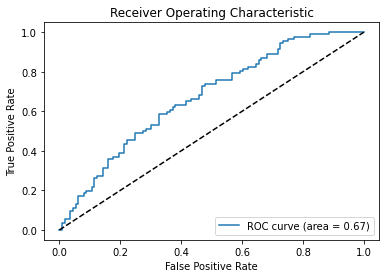

Accuracy: 0.624390243902439


In [95]:
import pandas as pd
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Assuming BrainDataset, GCNModel, and all necessary functions are defined above

# Add to your existing imports
from sklearn.metrics import log_loss

# Early stopping criteria parameters
patience = 5
min_delta = 0.001

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=patience, min_delta=min_delta)

class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

def custom_collate_fn(batch):
    graphs, labels = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    return batched_graph, labels

# Load the dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Splitting the dataset into training and test sets
indices = list(range(len(graphs)))

# Split the dataset into training, validation, and test sets
train_indices, temp_indices, train_labels, temp_labels = train_test_split(indices, labels, test_size=0.4, random_state=42)
val_indices, test_indices, val_labels, test_labels = train_test_split(temp_indices, temp_labels, test_size=0.5, random_state=42)

# Prepare the datasets
train_graphs = [graphs[i] for i in train_indices]
val_graphs = [graphs[i] for i in val_indices]
test_graphs = [graphs[i] for i in test_indices]

train_labels = [labels[i] for i in train_indices]
val_labels = [labels[i] for i in val_indices]
test_labels = [labels[i] for i in test_indices]

train_dataset = GraphDataset(train_graphs, train_labels)
val_dataset = GraphDataset(val_graphs, val_labels)
test_dataset = GraphDataset(test_graphs, test_labels)

# Prepare the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# Adjust model initialization with increased complexity
model = GCNModel(
    in_dim=Abide100.node_feat_dim, 
    hidden_dims=[256, 256, 128, 128],  # Increased model complexity
    n_classes=2,
    dropout_rates=[0.5, 0.5, 0.5],  # Added dropout to an additional layer
)


loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=5, min_delta=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=0.00001)

val_loss_min = np.Inf 

# Training Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batched_graph, labels in train_dataloader:
        logits = model(batched_graph)
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batched_graph, labels in val_dataloader:
            logits = model(batched_graph)
            val_loss += loss_fn(logits, labels).item()
    
    val_loss /= len(val_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_dataloader)}, Val Loss: {val_loss}")

    if val_loss < val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        val_loss_min = val_loss
    
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

    scheduler.step(val_loss)  # Learning rate scheduler step

# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        logits = model(batched_graph)
        probabilities = torch.softmax(logits, dim=1)[:, 1]
        all_labels.extend(labels.numpy())
        all_predictions.extend(probabilities.numpy())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Calculate accuracy
predicted_labels = np.round(all_predictions)
accuracy = accuracy_score(all_labels, predicted_labels)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print accuracy
print(f"Accuracy: {accuracy}")

## GCN Model - Features

In [81]:
class GCNModel(nn.Module):
    def __init__(self, in_dim, hidden_dims, n_classes, dropout_rates, activations, extra_feat_dim):
        super(GCNModel, self).__init__()
        self.layers = nn.ModuleList([
            GCNLayer(in_dim if i == 0 else hidden_dims[i - 1], hidden_dims[i], activations[i], dropout_rates[i], True)
            for i in range(len(hidden_dims))
        ])
        self.readout = MLPReadout(hidden_dims[-1], n_classes)
        # New linear layer to combine graph-level features with enhanced features
        self.combined_linear = nn.Linear(hidden_dims[-1] + extra_feat_dim, n_classes)

    def forward(self, g, node_features, edge_features):
        # Graph convolutional layers
        h = g.ndata['feat']
        for layer in self.layers:
            h = layer(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')

        # Combine graph-level features with node and edge features
        combined_features = torch.cat((hg, node_features, edge_features), dim=1)
        logits = self.combined_linear(combined_features)
        return logits

In [82]:
import pandas as pd
import numpy as np
import dgl
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
import ast
from collections import defaultdict

def custom_collate_fn(batch):
    graphs, labels, node_features, edge_features = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    # Convert node and edge features from list of numpy arrays to a single tensor
    node_features = torch.tensor(np.array(node_features), dtype=torch.float32)
    edge_features = torch.tensor(np.array(edge_features), dtype=torch.float32)
    return batched_graph, labels, node_features, edge_features

def extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance):
    # First, aggregate node data to ensure uniqueness
    aggregated_nodes = aggregate_node_data(df_nodes)
    
    edge_diffs = {
        ast.literal_eval(edge): (diff, p_val)
        for edge, diff, p_val in zip(df_edges['Edge Pairs'], df_edges['Mean Difference'], df_edges['P-Value'])
    }
    
    node_diffs = aggregated_nodes.set_index('Node')[['Mean Difference', 'Adjusted P-Value']].to_dict('index')
    
    features = []
    for graph in graphs:
        nx_graph = to_simple_graph(graph)
        graph_features = []
        
        # Adjusted for node features considering centrality significance
        for node, attrs in node_diffs.items():
            centrality_factor = centrality_significance.get(node, 1)
            if nx_graph.has_node(node):
                diff = attrs['Mean Difference'] * centrality_factor
                p_val = attrs['Adjusted P-Value']
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_node * centrality_factor])
        
        # Adjusted for edge features considering centrality significance
        for edge, values in edge_diffs.items():
            centrality_factor = centrality_significance.get(edge, 1)
            if nx_graph.has_edge(*edge):
                diff, p_val = values
                diff *= centrality_factor
                graph_features.extend([diff * transform_p_value(p_val)])
            else:
                graph_features.extend([global_median_edge * centrality_factor])
        
        features.append(graph_features)
    
    return np.array(features)

def to_simple_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)
    simple_graph = nx.Graph()
    for u, v, data in g.edges(data=True):
        w = data.get('weight', 1.0)  # Default weight is 1.0 if 'weight' attribute is missing
        if simple_graph.has_edge(u, v):
            simple_graph[u][v]['weight'] += w
        else:
            simple_graph.add_edge(u, v, weight=w)
    return simple_graph

def transform_p_value(p_val):
    return -np.log10(p_val)

def compute_centrality_significance(df_nodes, df_edges):
    centrality_significance = defaultdict(int)
    for node in df_nodes['Node']:
        centrality_significance[node] += 1
    for edge in df_edges['Edge Pairs'].apply(ast.literal_eval):
        centrality_significance[edge] += 1
    return centrality_significance

def aggregate_node_data(df):
    # Aggregating 'Mean Difference' by sum and averaging 'Adjusted P-Value'
    aggregated_data = df.groupby('Node').agg({
        'Mean Difference': 'sum',
        'Adjusted P-Value': 'mean'
    }).reset_index()
    return aggregated_data


# Load CSV files for nodes and edges with their respective metrics
df_nodes = pd.read_csv('significant_nodes.csv')
df_edges = pd.read_csv('significant_edges.csv')

# Assuming BrainDataset is already loaded as `Abide100`
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Calculate centrality significance
centrality_significance = compute_centrality_significance(df_nodes, df_edges)

# Compute global medians for nodes and edges
global_median_node = np.median(df_nodes['Mean Difference'].values)
global_median_edge = np.median(df_edges['Mean Difference'].values)

# Extract enhanced features for all graphs
X_enhanced = extract_enhanced_features(graphs, df_nodes, df_edges, global_median_node, global_median_edge, centrality_significance)

# Split the dataset into training and test sets along with their enhanced features
X_train, X_test, y_train, y_test, features_train, features_test = train_test_split(graphs, labels, X_enhanced, test_size=0.2, random_state=42)

# Define the enhanced dataset including node and edge features for both training and testing
class EnhancedGraphDataset(Dataset):
    def __init__(self, graphs, labels, features):
        self.graphs = graphs
        self.labels = labels
        self.features = features  # This now represents your enhanced features
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx], self.features[idx]  # Update this line as per your needs

def custom_collate_fn(batch):
    graphs, labels, features = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.long)
    features = torch.tensor(features, dtype=torch.float32)  # Ensure features are tensors
    return batched_graph, labels, features

# Create instances of EnhancedGraphDataset for training and testing
train_dataset = EnhancedGraphDataset(X_train, y_train, features_train)
test_dataset = EnhancedGraphDataset(X_test, y_test, features_test)

# DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# Example dimensionality, adjust according to your actual feature sizes
node_features_dim = features_train.shape[1]
edge_features_dim = features_train.shape[1]  # Update this with correct edge feature dimension
extra_feat_dim = node_features_dim + edge_features_dim

model = GCNModel(
    in_dim=Abide100.node_feat_dim, 
    hidden_dims=[64, 64],  
    n_classes=2,           
    dropout_rates=[0.5, 0.5],
    activations=[F.relu, F.relu],
    extra_feat_dim=extra_feat_dim  # Include the extra feature dimension
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batched_graph, labels, node_features, edge_features in train_dataloader:
        logits = model(batched_graph, node_features, edge_features)
        loss = loss_fn(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")


# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for batched_graph, labels, node_features, edge_features in test_dataloader:
        logits = model(batched_graph, node_features, edge_features)
        probabilities = torch.softmax(logits, dim=1)[:, 1]
        all_labels.extend(labels.numpy())
        all_predictions.extend(probabilities.numpy())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Calculate accuracy
predicted_labels = np.round(all_predictions)
accuracy = accuracy_score(all_labels, predicted_labels)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print accuracy
print(f"Accuracy: {accuracy}")

[!] Dataset:  Abide100Dataset
[]


  0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 2.9162s


ValueError: not enough values to unpack (expected 4, got 3)

## GAT Model

In [105]:
class GATModel(nn.Module):
    def __init__(self, in_dim, hidden_dims, n_classes, num_heads, dropout_rate):
        super(GATModel, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layers = nn.ModuleList()
        
        # Correctly calculate the input and output dimensions for each layer
        self.layers.append(dglnn.GATConv(in_dim, hidden_dims[0] // num_heads[0], num_heads=num_heads[0]))
        for i in range(1, len(hidden_dims)):
            # Corrected to handle the multiplicative effect of num_heads on the feature size
            self.layers.append(dglnn.GATConv(
                hidden_dims[i-1] * num_heads[i-1],
                hidden_dims[i] // num_heads[i],
                num_heads=num_heads[i]))
        
        # Output layer handling
        self.classifier = nn.Linear(hidden_dims[-1] * num_heads[-1], n_classes)
    
    def forward(self, g):
        h = g.ndata['feat']
        for layer in self.layers[:-1]:
            h = layer(g, h).view(h.size(0), -1)  # Flatten operation adjusted for attention heads
            h = self.dropout(F.elu(h))
        h = self.layers[-1](g, h).mean(1)  # Aggregate head outputs only in the last layer
        h = self.dropout(h)
        return self.classifier(h)

In [106]:
import pandas as pd
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Assuming BrainDataset, GCNModel, and all necessary functions are defined above

# Add to your existing imports
from sklearn.metrics import log_loss

# Early stopping criteria parameters
patience = 5
min_delta = 0.001

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=patience, min_delta=min_delta)

class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

def custom_collate_fn(batch):
    graphs, labels = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    return batched_graph, labels

# Load the dataset
Abide100 = BrainDataset('Abide100Dataset')
graphs, labels = zip(*[(graph, label) for graph, label in Abide100])

# Splitting the dataset into training and test sets
indices = list(range(len(graphs)))

# Split the dataset into training, validation, and test sets
train_indices, temp_indices, train_labels, temp_labels = train_test_split(indices, labels, test_size=0.4, random_state=42)
val_indices, test_indices, val_labels, test_labels = train_test_split(temp_indices, temp_labels, test_size=0.5, random_state=42)

# Prepare the datasets
train_graphs = [graphs[i] for i in train_indices]
val_graphs = [graphs[i] for i in val_indices]
test_graphs = [graphs[i] for i in test_indices]

train_labels = [labels[i] for i in train_indices]
val_labels = [labels[i] for i in val_indices]
test_labels = [labels[i] for i in test_indices]

train_dataset = GraphDataset(train_graphs, train_labels)
val_dataset = GraphDataset(val_graphs, val_labels)
test_dataset = GraphDataset(test_graphs, test_labels)

# Prepare the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

# Adjust model initialization with increased complexity
# Corrected model initialization
model = GATModel(
    in_dim=Abide100.node_feat_dim,
    hidden_dims=[256, 256, 128, 128],  # Increased model complexity
    n_classes=2,
    num_heads=[4, 4, 6, 6],  # Number of attention heads for each layer
    dropout_rate=0.6  # Correct parameter name and value
)



loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=5, min_delta=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=0.00001)

val_loss_min = np.Inf 

# Training Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batched_graph, labels in train_dataloader:
        logits = model(batched_graph)
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batched_graph, labels in val_dataloader:
            logits = model(batched_graph)
            val_loss += loss_fn(logits, labels).item()
    
    val_loss /= len(val_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_dataloader)}, Val Loss: {val_loss}")

    if val_loss < val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        val_loss_min = val_loss
    
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

    scheduler.step(val_loss)  # Learning rate scheduler step

# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        logits = model(batched_graph)
        probabilities = torch.softmax(logits, dim=1)[:, 1]
        all_labels.extend(labels.numpy())
        all_predictions.extend(probabilities.numpy())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Calculate accuracy
predicted_labels = np.round(all_predictions)
accuracy = accuracy_score(all_labels, predicted_labels)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print accuracy
print(f"Accuracy: {accuracy}")

[!] Dataset:  Abide100Dataset
[]


  0%|          | 0/1025 [00:00<?, ?it/s]

Time taken: 3.0649s


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3200x256 and 1024x256)